In [1]:
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp

import optax

import matplotlib.pyplot as plt

from gpax import ExactGP, SparseGP, GibbsKernel, HomoscedasticNoise, HeteroscedasticNoise
from gpax.utils import constrain, unconstrain, randomize, train_fn
from gpax.plotting import plot_posterior

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from stheno import GP, EQ

import lab.jax as B
from matrix import Dense, dense

import regdata as rd

import pprint
pp = pprint.PrettyPrinter(depth=4)

# from jax.config import config
# config.update("jax_debug_nans", True)

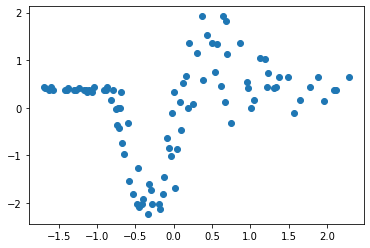

In [2]:
# X = jnp.linspace(-1, 1, 100).reshape(-1, 1)
# # X = jnp.concatenate([X[:40], X[60:]])
# key = jax.random.PRNGKey(0)
# y = jnp.sin(2 * jnp.pi * X) + jax.random.normal(key, X.shape)*0.2

X, y, X_test = rd.MotorcycleHelmet().get_data()

plt.scatter(X, y);

## Exact GP

In [12]:
X_inducing = X[::20]
print(X_inducing.shape)

kernel = GibbsKernel(X_inducing=X_inducing)
noise = HeteroscedasticNoise(use_kernel_inducing=True)
model = ExactGP(kernel=kernel, noise=noise)
prior = tfd.Normal(loc=0.0, scale=1.0)
def loss_fun(params):
#     print(params["kernel"]["latent_log_scale"])
#     print(prior.log_prob(params["kernel"]["latent_log_scale"]).sum())
    return -model.log_probability(params, X, y)

(5, 1)


In [13]:
key = jax.random.PRNGKey(0)
params = model.initialise_params(key, X, X_inducing)
bijectors = model.get_bijectors()

params = unconstrain(params, bijectors)
key = jax.random.PRNGKey(1)
params = randomize(params, key)
params = constrain(params, bijectors)
loss_fun(params)

DeviceArray(124.538025, dtype=float32)

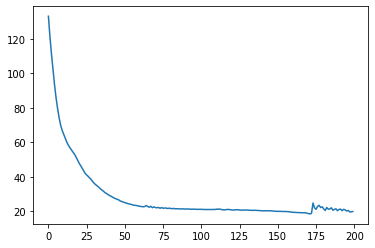

In [24]:
key = jax.random.PRNGKey(0)
params = model.initialise_params(key, X, X_inducing)
bijectors = model.get_bijectors()

params = unconstrain(params, bijectors)
key = jax.random.PRNGKey(4)
x_ind = params["kernel"]["X_inducing"]
params = randomize(params, key)
params["kernel"]["X_inducing"] = x_ind

# print(ravel_pytree(constrain(params, bijectors)))

optimizer = optax.adam(1e-1)
num_epochs = 200
# B.epsilon = 10.
result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)

plt.plot(result["loss_history"]);

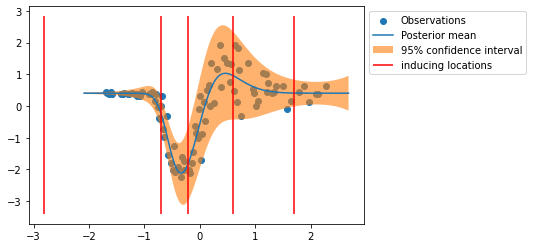

In [25]:
params = jax.tree_map(lambda x: x[-1], result["params_history"])
params = constrain(params, bijectors)
ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6);
plt.vlines(params['kernel']['X_inducing'], *plt.ylim(), label='inducing locations', color='red')
ax.legend(bbox_to_anchor=(1,1));

## Sparse GP

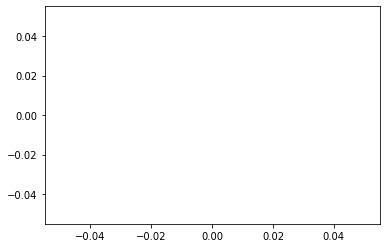

In [54]:
model = SparseGP(
    kernel=GibbsKernel(X_inducing=X_inducing),
    noise=HeteroscedasticNoise(),
    method="vfe", # "vfe" or "fitc" or "dtc"
)

def loss_fun(params):
    return -model.elbo(params, X, y)

optimizer = optax.adam(1e-2)
num_epochs = 10

params = model.initialise_params(key, X, X_inducing)
bijectors = model.get_bijectors()

params = unconstrain(params, bijectors)
key = jax.random.PRNGKey(10)
x_ind, x_ind2 = params["X_inducing"], params["kernel"]["X_inducing"]
params = randomize(params, key)
params["X_inducing"], params["kernel"]["X_inducing"] = x_ind, x_ind2
result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)

plt.plot(result["loss_history"]);

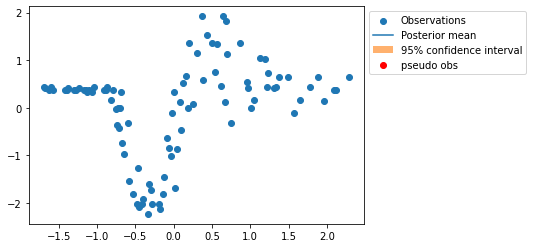

In [53]:
params = jax.tree_map(lambda x: x[660], result["params_history"])
params = constrain(params, bijectors)
ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6)
f = model.get_gp(params)
pseudo_obs = model.get_pseudo_obs(params, f, X, y)
ax.plot(params['X_inducing'], B.dense(pseudo_obs.mu(f.measure)), 'o', color='red', label='pseudo obs');
ax.legend(bbox_to_anchor=(1,1));

## Appendix

In [3]:
from gpflex.core.kernels import FlexKernel

In [4]:
kernel = FlexKernel(latent_x=X[::10])
values, unravel_fn = ravel_pytree(kernel)
values = randomize(values, jax.random.PRNGKey(10))
kernel = unravel_fn(values)
cov = kernel(X, X)
c = cov + jnp.diag(jax.random.normal(jax.random.PRNGKey(14), (cov.shape[0], )))
print(jnp.linalg.matrix_rank(c))
# jnp.linalg.cholesky(c)

94


In [5]:
jnp.diag(cov)

DeviceArray([0.25713083, 0.18668484, 0.2638846 , 0.1859538 , 0.17193638,
             0.19232759, 0.28364548, 0.18640848, 0.54728099, 0.88132095,
             0.21959429, 0.38863799, 0.6868704 , 0.32372735, 0.89801692,
             0.22872787, 0.56739167, 0.2504248 , 0.22817291, 0.80162985,
             0.24382766, 0.18835323, 0.199443  , 0.58877252, 0.74050689,
             0.61685584, 0.3402994 , 0.31104836, 0.64372427, 0.29961557,
             0.89294793, 0.21917057, 0.30442286, 0.23425928, 0.870084  ,
             0.30163043, 0.57988265, 0.32711419, 0.33155548, 0.23967333,
             0.19553189, 0.32214927, 0.18600322, 0.18372875, 0.63094238,
             0.20079695, 0.8647269 , 0.25249666, 0.20167321, 0.75328975,
             0.31565963, 0.32441901, 0.53371775, 0.66949661, 0.32261211,
             0.60278963, 0.21252353, 0.56099321, 0.18619553, 0.21263642,
             0.19263938, 0.42128887, 0.89371705, 0.2093824 , 0.82179309,
             0.48135015, 0.36837944, 0.22281665, 0.

In [19]:
kernel = GibbsKernel(X_inducing=X[::10])
params = kernel.initialise_params(jax.random.PRNGKey(123), X_inducing=X[::10])
bijectors = kernel.get_bijectors()
params = unconstrain(params, bijectors)
params = randomize(params, jax.random.PRNGKey(321))
params = constrain(params, bijectors)
cov = B.dense(kernel(params)(X, X))
c = cov + jnp.abs(jnp.diag(jax.random.normal(jax.random.PRNGKey(14), (cov.shape[0], ))))
jnp.linalg.matrix_rank(c)

jnp.linalg.cholesky(c)

DeviceArray([[ 1.34658176,  0.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             [ 0.91962198,  0.87256872,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             [ 1.10781309,  0.21754679,  0.60718973, ...,  0.        ,
               0.        ,  0.        ],
             ...,
             [ 0.32891668,  0.71650877, -0.16354719, ...,  0.7615721 ,
               0.        ,  0.        ],
             [ 0.88638372,  0.81099148,  0.00763058, ...,  0.00355779,
               0.37869293,  0.        ],
             [ 0.0801588 ,  0.29709424, -0.08685412, ...,  0.00837769,
              -0.0060519 ,  0.64562375]], dtype=float64)

In [33]:
from stheno.jax import EQ, GP

In [15]:
x = jax.random.normal(jax.random.PRNGKey(10), (5,2))
GP(EQ())(x, jnp.array(0.1)).noise
# jnp.array([0.1]).shape

<diagonal matrix: batch=(), shape=(5, 5), dtype=float64
 diag=[0.1 0.1 0.1 0.1 0.1]>

In [32]:
EQ()(x, x)

<dense matrix: batch=(), shape=(5, 5), dtype=float64
 mat=[[1.000e+00 4.865e-01 3.646e-01 1.061e-03 2.854e-03]
      [4.865e-01 1.000e+00 4.375e-01 4.991e-03 2.777e-02]
      [3.646e-01 4.375e-01 1.000e+00 1.041e-03 2.794e-02]
      [1.061e-03 4.991e-03 1.041e-03 1.000e+00 1.270e-04]
      [2.854e-03 2.777e-02 2.794e-02 1.270e-04 1.000e+00]]>

In [31]:
B.dense(EQ().select(1)(x, x)) * B.dense(EQ().select(2)(x,x))

DeviceArray([[1.        , 0.52989886, 0.64234285, 0.22303027, 0.00321975],
             [0.52989886, 1.        , 0.75629176, 0.32947335, 0.04082509],
             [0.64234285, 0.75629176, 1.        , 0.67992447, 0.04878733],
             [0.22303027, 0.32947335, 0.67992447, 1.        , 0.14922711],
             [0.00321975, 0.04082509, 0.04878733, 0.14922711, 1.        ]],            dtype=float64)

In [15]:
aa = jnp.arange(4, dtype=float)
aa@aa

DeviceArray(14., dtype=float64)

In [16]:
aa

DeviceArray([0., 1., 2., 3.], dtype=float64)